# Deep Learning - Bank Note Authentication

In [2]:
import warnings

import matplotlib.pyplot
import numpy.random
import pandas
import seaborn
import tensorflow
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

random_state = 42
numpy.random.seed(random_state)

# ignore the irrelevant warnings, it's just tensorflow being tensorflow

2024-01-12 01:02:54.892222: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 01:02:55.238033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 01:02:55.238153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 01:02:55.268666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 01:02:55.335682: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 01:02:55.336927: I tensorflow/core/platform/cpu_feature_guard.cc:1

# 1. Obtain

In [3]:
banknote = pandas.read_csv('data_banknote_authentication.txt')
banknote.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
3.6216,1371.0,0.43,2.84,-7.04,-1.77,0.50,2.81,6.82
8.6661,1371.0,1.92,5.87,-13.77,-1.71,2.31,6.81,12.95
-2.8073,1371.0,1.40,4.31,-5.29,-1.55,0.62,3.18,17.93
-0.44699,1371.0,-1.19,2.10,-8.55,-2.42,-0.59,0.39,2.45
0,1371.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00


In [4]:
# credits: https://archive.ics.uci.edu/dataset/267/banknote+authentication
features = ['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Class']
banknote.columns = features
banknote.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Variance,1371.0,0.43,2.84,-7.04,-1.77,0.50,2.81,6.82
Skewness,1371.0,1.92,5.87,-13.77,-1.71,2.31,6.81,12.95
Kurtosis,1371.0,1.40,4.31,-5.29,-1.55,0.62,3.18,17.93
Entropy,1371.0,-1.19,2.10,-8.55,-2.42,-0.59,0.39,2.45
Class,1371.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00


This dataset is about banknotes and whether they are authentic or not.
It contains various measurements of the banknotes.
The goal is to predict whether a banknote is authentic or not based on the measurements.

# 2. Scrub (+ Explore)

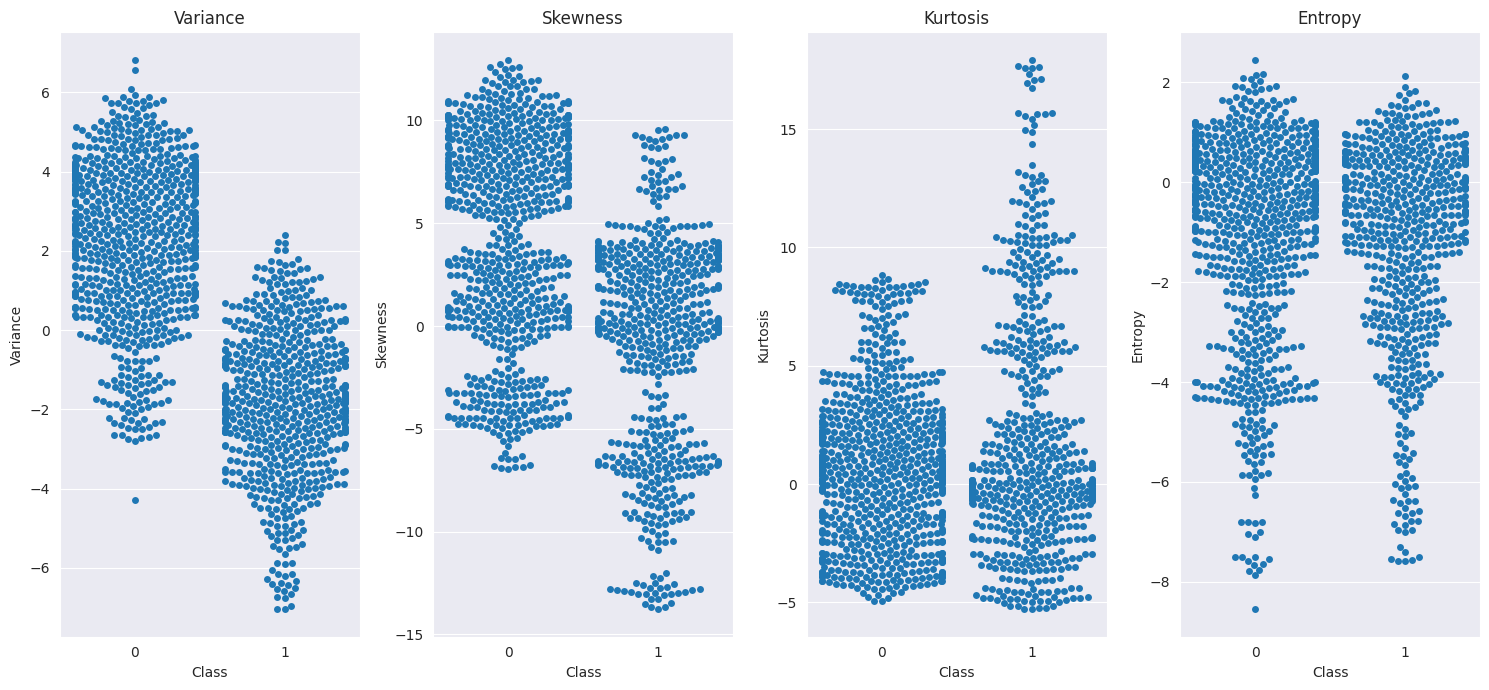

In [5]:
plot_for_overview, sub_plot = matplotlib.pyplot.subplots(1, len(features)-1, figsize=(15, 7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for each_iteration, each_feature in enumerate(features[:-1]):
        sub_plot[each_iteration].set_title(each_feature)
        seaborn.swarmplot(x="Class", y=each_feature, data=banknote, ax=sub_plot[each_iteration])

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

- So far, just by eyeballing, there is nothing to scrub
    - no missing values, no outliers in Kurtosis and Entropy(?), slight bias towards 0 class, no impossible values
- other than that, the features look like they could be useful for predicting the class
    - the higher the Variance or Skewness, the more likely it is that the banknote is fake
    - the higher the Kurtosis, the more likely it is that the banknote is authentic
    - Entropy seems to behave similarly for both classes  

# 3. Model (+ Tuning)

In [6]:
X = banknote.drop(['Class'], axis=1)
y = banknote['Class'].values

X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=1/3, random_state=random_state, stratify=y)

In [7]:
# Tensorflow Keras, because it's the future, and it's easy to use
# https://www.statista.com/statistics/793840/worldwide-developer-survey-most-used-frameworks/
# https://www.datacamp.com/blog/top-ai-frameworks-and-libraries
model = keras.Sequential()
# input - hidden - output layers
# credits: https://keras.io/api/layers/activations/
# no activation function in the input, because it is just passing the values on to the hidden layers
model.add(keras.layers.Dense(units=4, input_dim=4)) # 4 features means 4 neurons in the input layer 
# relu prevents the output of being negative, which saves computing power and makes room for more complex calculations
model.add(keras.layers.Dense(units=4,activation=tensorflow.nn.relu)) 
# 1 output neuron, because it is predicting 1-single class
# sigmoid transforms the output to a probability between 0 and 1, indicating the probability of the input belonging to either class 0 or 1
model.add(keras.layers.Dense(units=1,activation=tensorflow.nn.sigmoid))

# compile (with optimizer)
# https://keras.io/api/metrics/probabilistic_metrics/#binarycrossentropy-class
model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

- No difference between adam and (native) rmsprop
    - choosing adam, because it is more efficient for large datasets (which this is not *yet*)
- 1 Hidden Layer with 4 Units is the minimum amount of setup required to build this network and is also coincidentally enough to get good results
    - Other hidden layer and neuron combinations only took longer to compute and did not improve anything
        - in example: 4 hidden layers with sth like 8-16-8-4 neuron distribution is not any better than 1 single hidden layer with 4 neurons

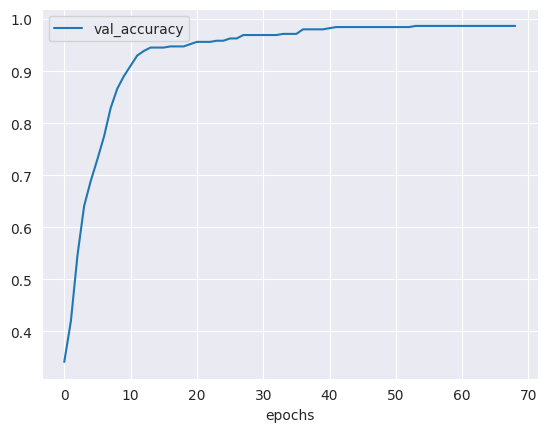

In [8]:
# if the val_loss does not improve for 8 epochs, please_stop_training
please_stop_training = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# epochs: algorithm cycles through 128 times, unless it is stopped earlier by please_stop_training
history_of_training_data = model.fit(X_train, y_train, epochs=128, validation_data=(X_test, y_test), callbacks=please_stop_training, verbose=0)
matplotlib.pyplot.plot(history_of_training_data.history['val_accuracy'], label='val_accuracy')
matplotlib.pyplot.xlabel('epochs')
matplotlib.pyplot.legend()

In [9]:
# BOLDLY assuming "0.5" as threshold (credits: https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/)
y_pred = (model.predict(X_test) >= 0.5).astype(numpy.int32) # credits: https://stackoverflow.com/q/69980343
print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       254
           1       0.97      1.00      0.99       203

    accuracy                           0.99       457
   macro avg       0.99      0.99      0.99       457
weighted avg       0.99      0.99      0.99       457
